In [174]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display

In [65]:
wheat_path = "./data"
train_path = os.path.join(wheat_path, "train")
test_path = os.path.join(wheat_path, "test")

print('Number of train images is {}'.format(len(os.listdir(train_path))))
print('Number of test images is {}'.format(len(os.listdir(test_path))))

Number of train images is 3422
Number of test images is 10


We have only 10 test images here, other test images will be used to evaluate the prediction models during the submission.

Just 3422 images for the training seems to be not much at all. Data augmentation techniques will be definetely required in this competition.

In [66]:
train_csv = pd.read_csv(os.path.join(wheat_path, "train.csv"))
print(train_csv.head())

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1


In [67]:
tr_img_df = pd.DataFrame({"image_id":[fn.split(".")[0] for fn in os.listdir(train_path)]})

tr_img_df = tr_img_df.merge(train_csv, on='image_id', how='left')

# split bbox column
bbox_items = tr_img_df.bbox.str.split(',', expand=True)
tr_img_df['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
tr_img_df['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
tr_img_df['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
tr_img_df['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)


print(tr_img_df.head())

    image_id   width  height               bbox     source  bbox_xmin  \
0  00333207f  1024.0  1024.0  [0, 654, 37, 111]  arvalis_1        0.0   
1  00333207f  1024.0  1024.0  [0, 817, 135, 98]  arvalis_1        0.0   
2  00333207f  1024.0  1024.0   [0, 192, 22, 81]  arvalis_1        0.0   
3  00333207f  1024.0  1024.0   [4, 342, 63, 38]  arvalis_1        4.0   
4  00333207f  1024.0  1024.0  [82, 334, 82, 81]  arvalis_1       82.0   

   bbox_ymin  bbox_width  bbox_height  
0      654.0        37.0        111.0  
1      817.0       135.0         98.0  
2      192.0        22.0         81.0  
3      342.0        63.0         38.0  
4      334.0        82.0         81.0  


### Plot some image

In [68]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(os.path.join(train_path , img_id + '.jpg'))
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

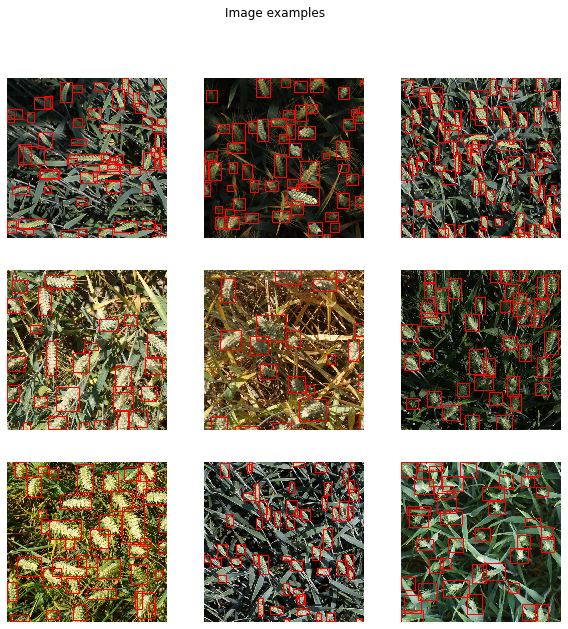

In [69]:
plot_image_examples(tr_img_df)

# Count number of bounding boxes per image

In [73]:
tr_img_df["count"] = tr_img_df.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = tr_img_df.groupby('image_id').sum().reset_index()

In [84]:
print(train_images_count.loc[:, ["image_id", "count"]])
print(train_images_count["count"].describe())

       image_id  count
0     00333207f     55
1     005b0d8bb     20
2     006a994f7     25
3     00764ad5d     41
4     00b5c6764      0
...         ...    ...
3417  ffbb9c623      0
3418  ffbf75e5b     52
3419  ffbfe7cc0     34
3420  ffc870198     41
3421  ffdf83e42     39

[3422 rows x 2 columns]
count    3422.000000
mean       43.189071
std        20.887616
min         0.000000
25%        27.000000
50%        42.000000
75%        59.000000
max       116.000000
Name: count, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014B4B14D080>]],
      dtype=object)

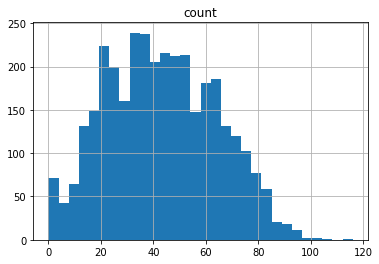

In [83]:
train_images_count.loc[:, ["image_id", "count"]].hist(bins=30)

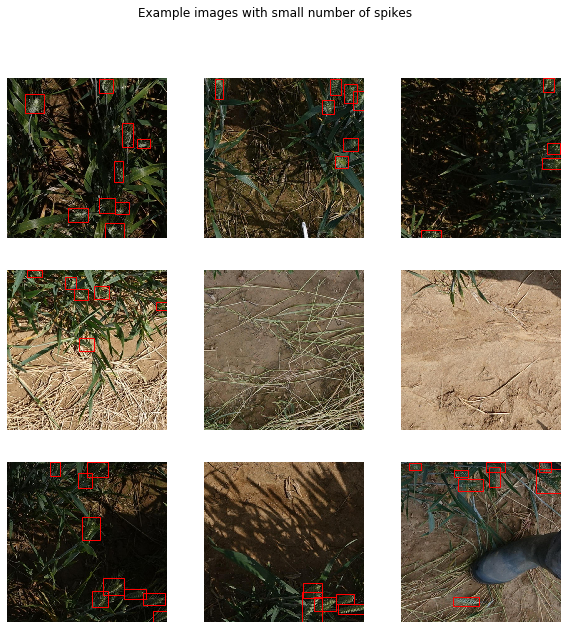

In [81]:
# plot some examples with small number of spikes per image

less_bbox_img = train_images_count[train_images_count["count"] < 10].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(less_bbox_img)], title='Example images with small number of spikes')

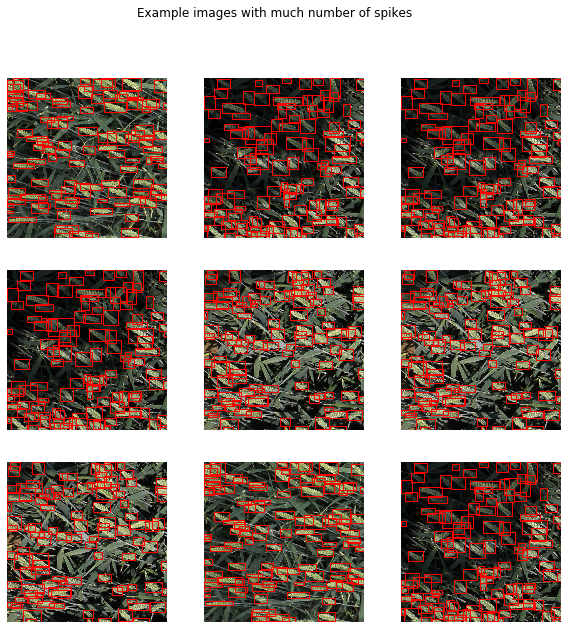

In [86]:
more_bbox_img = train_images_count[train_images_count["count"] > 100].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(more_bbox_img)], title='Example images with much number of spikes')

# Area of bounding boxes

529788.0
count    147793.000000
mean       6843.356576
std        5876.326590
min           2.000000
25%        3658.000000
50%        5488.000000
75%        8272.000000
max      529788.000000
Name: box_area, dtype: float64


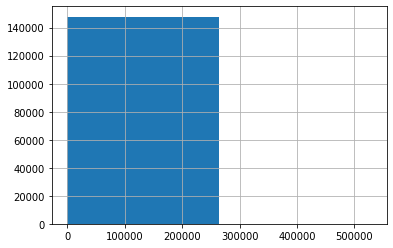

In [97]:
tr_img_df["box_area"] = tr_img_df["bbox_height"] * tr_img_df["bbox_width"]
tr_img_df["box_area"].hist(bins = 2)
print(tr_img_df["box_area"].max())
print(tr_img_df["box_area"].describe())

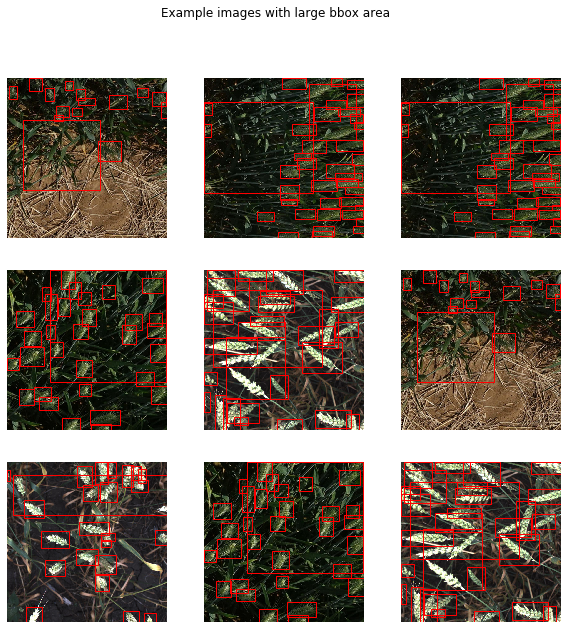

In [98]:
large_boxes_ids = tr_img_df[tr_img_df['box_area'] > 200000].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')

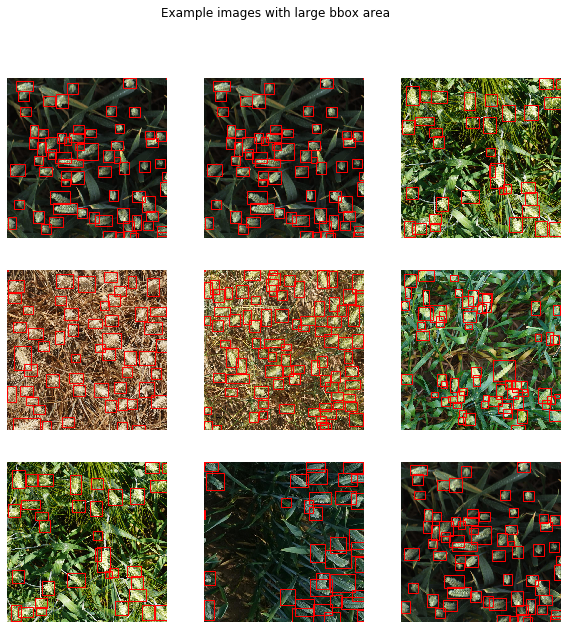

In [100]:
small_boxes_ids = tr_img_df[(tr_img_df['box_area'] < 50) & (tr_img_df['box_area'] > 0)].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(small_boxes_ids)], title='Example images with large bbox area')

In [101]:
# compute the total bounding boxes area per image
area_per_image = tr_img_df.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['box_area'] = area_per_image_percentage['box_area'] / (1024*1024) * 100

count    3422.000000
mean       28.186627
std        12.075984
min         0.000000
25%        21.164393
50%        27.809238
75%        34.421110
max       108.197308
Name: box_area, dtype: float64


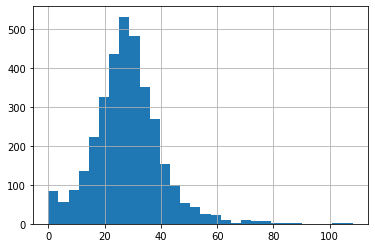

In [106]:
area_per_image_percentage['box_area'].hist(bins=30)
print(area_per_image_percentage['box_area'].describe())

This observation can be used to validate the predictions of the resulting model. The percentage of predicted bounding boxes area should be normally distributed too.

We can also see that the maximum is actually greater than 100%. This means that the bounding boxes are overlapping.

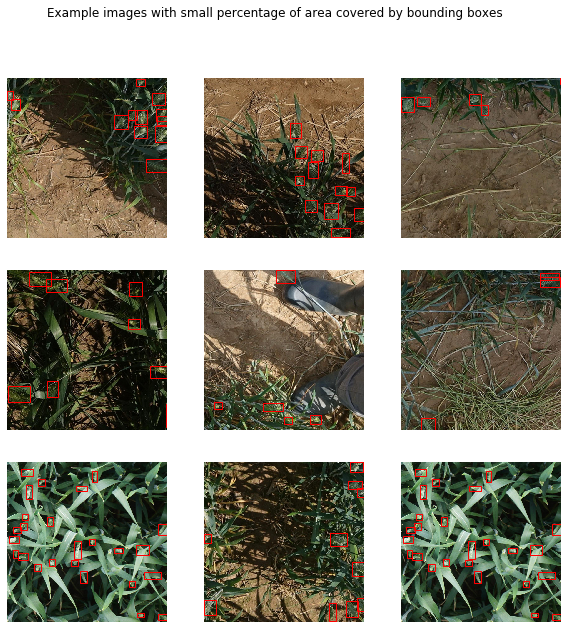

In [107]:
small_area_perc_ids = area_per_image_percentage[area_per_image_percentage['box_area'] < 7].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(small_area_perc_ids)], title='Example images with small percentage of area covered by bounding boxes')

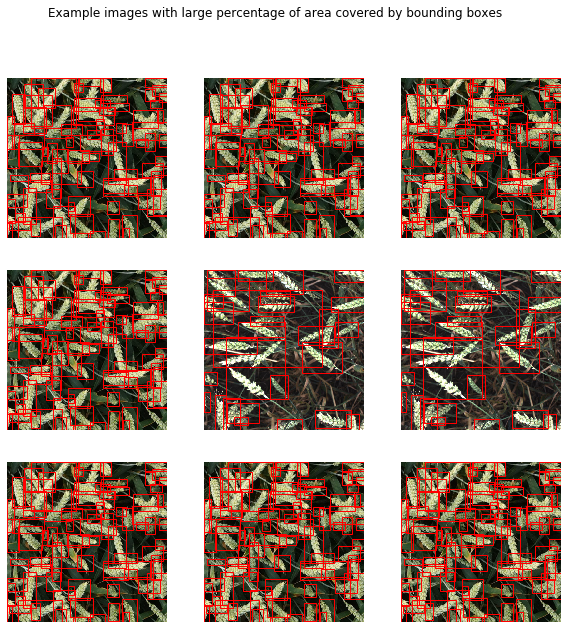

In [108]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['box_area'] > 95].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')

In [128]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(os.path.join(train_path , img_id + '.jpg'))
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [129]:
images_df = pd.DataFrame(tr_img_df.image_id.unique())
images_df.columns = ['image_id']

In [130]:
# add brightness to the dataframe
brightness_df = add_brightness(images_df)

tr_img_df = tr_img_df.merge(brightness_df, on='image_id')

count    147842.000000
mean         78.662571
std          23.931198
min          20.159955
25%          63.477330
50%          78.266934
75%          97.540001
max         164.207220
Name: brightness, dtype: float64

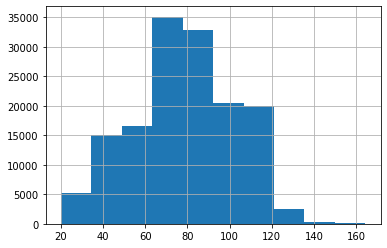

In [132]:
tr_img_df["brightness"].hist()
tr_img_df["brightness"].describe()

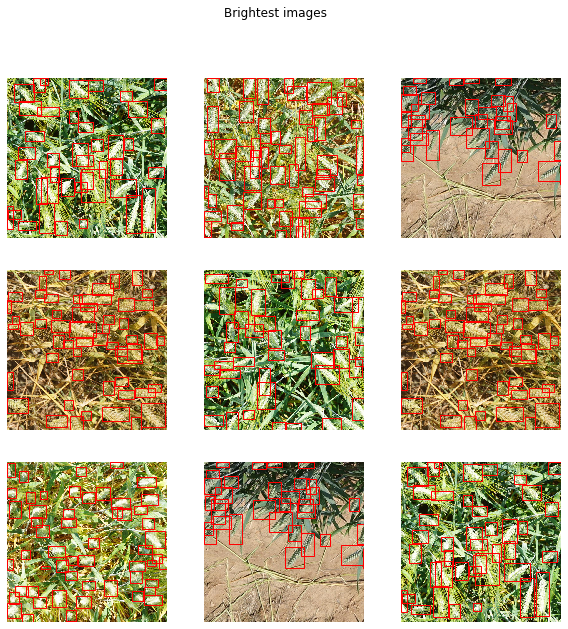

In [133]:
bright_ids = tr_img_df[tr_img_df['brightness'] > 130].image_id
plot_image_examples(tr_img_df[tr_img_df.image_id.isin(bright_ids)], title='Brightest images')

# Data Augmentation

https://blog.csdn.net/u012897374/article/details/80142744

In [150]:
import imgaug as ia
import imgaug.augmenters as iaa
print(tr_img_df.iloc[0])

image_id                00333207f
width                        1024
height                       1024
bbox            [0, 654, 37, 111]
source                  arvalis_1
bbox_xmin                       0
bbox_ymin                     654
bbox_width                     37
bbox_height                   111
count                           1
box_area                     4107
brightness_x              131.099
brightness_y              131.099
brightness                131.099
Name: 0, dtype: object


In [175]:

# example_transforms = iaa.Sequential([
#     albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
#     albu.HorizontalFlip(p=0.5),
#     albu.VerticalFlip(p=0.5),
#     albu.OneOf([albu.RandomContrast(),
#                 albu.RandomGamma(),
#                 albu.RandomBrightness()], p=1.0),
#     albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))


# def transfor_img_bbox(tr_img_df):
#     idx = np.random.randint(len(tr_img_df), size=1)[0]
#     print(idx)
#     print(tr_img_df.loc[idx, "image_id"])
#     img = Image.open(os.path.join(train_path, tr_img_df.loc[idx, "image_id"] + ".jpg"))
# #     img = Image.open(os.path.join(train_path , img_id + '.jpg'))
#     display(img)
# #     bbs = [
# #         [ia.BoundingBox(x1=10.5, y1=15.5, x2=30.5, y2=50.5)],
# #         [ia.BoundingBox(x1=10.5, y1=20.5, x2=50.5, y2=50.5),
# #          ia.BoundingBox(x1=40.5, y1=75.5, x2=70.5, y2=100.5)]
# #     ]

# #     seq = iaa.Sequential([
# #         iaa.Crop(px=(0, 10)),
# #         iaa.Fliplr(0.5),
# #         iaa.AdditiveGaussianNoise(scale=0.05*255),
# #         iaa.Affine(translate_px={"x": (1, 5)})
# #     ])

# #     images_aug, bbs_aug = seq(images=images, bounding_boxes=bbs)
# #     print(images_aug.shape)
# #     print(len(bbs_aug))
# #     print(bbs_aug)

38919
46630486d


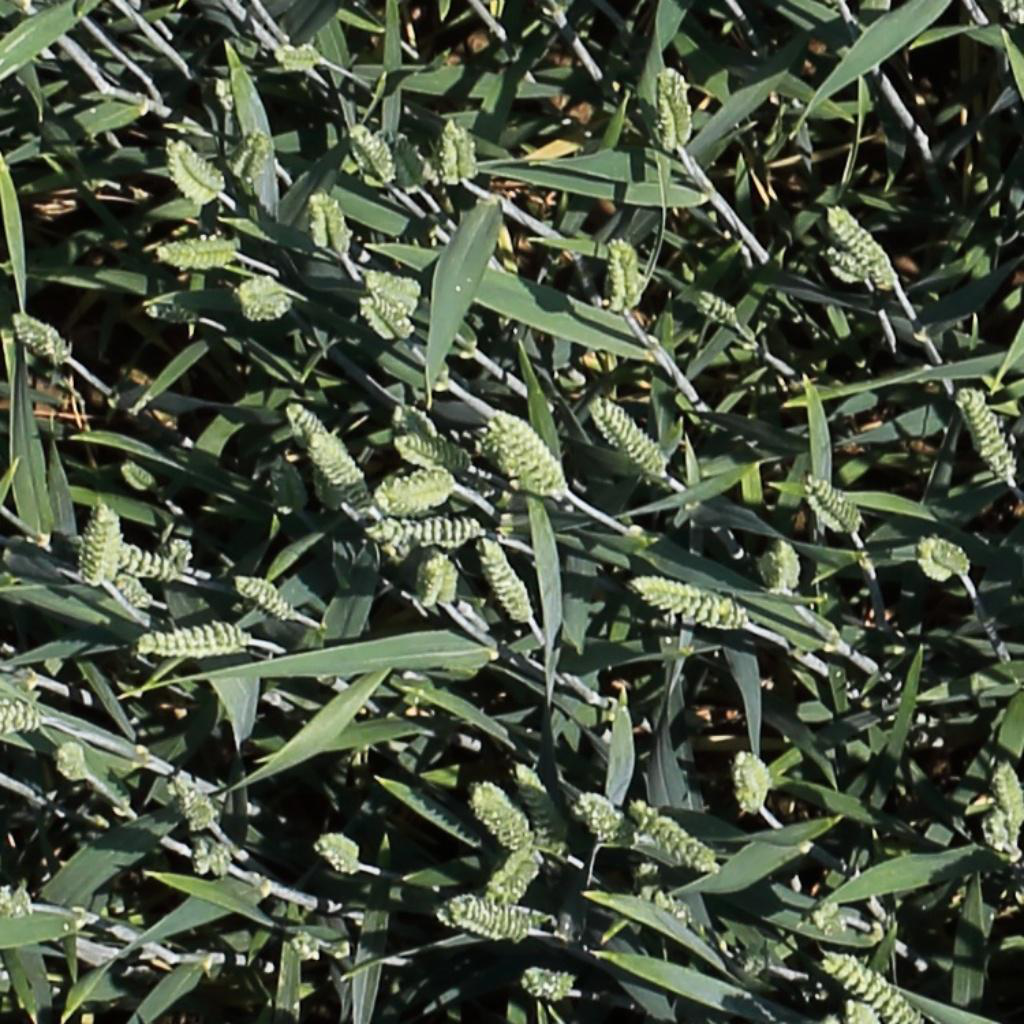

In [176]:
# transfor_img_bbox(tr_img_df)